Dependencies

In [1]:
# import the packages 
import os
#import cv2
import numpy as np
import gdal
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure

Populating the interactive namespace from numpy and matplotlib


In [2]:
#model dependencies
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, model_from_json, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras.layers import (
    Conv2D,
    UpSampling2D,
    MaxPooling2D,
    Input,
    Conv2DTranspose,
    Flatten,
    BatchNormalization,
    Activation,
    concatenate
)
from tensorflow.keras.layers import RepeatVector, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from scipy import interpolate
from osgeo import gdal_array
from pathlib import Path
from functools import partial
from sklearn.metrics import jaccard_score
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
set_session(tf.compat.v1.Session(config=config))

from sklearn.model_selection import train_test_split

## Part 1: Data preparation

In this part we prepare the input data for the model.


In [3]:
# define dataset directory

base_path = r"D:\informal"
image_path = os.path.join(base_path, "images")
label_path = os.path.join(base_path, "labels")

print(image_path)
print(label_path)

D:\informal\images
D:\informal\labels


In [4]:
# Structuring input data in 3D arrays

def gtiff_to_array(file_path):
    """Takes a file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis=2)


def fetch_tiles(path):
    """Parse the images into a dictionary of numpy arrays."""
    tiles = {}
    for f in sorted(os.listdir(path)):
        fdir = os.path.join(path, f)
        _, ext = os.path.splitext(f)
        if ext.lower() == ".tif":
            imgtype = f[-10:-4]
            tiles[imgtype] = gtiff_to_array(fdir)
    return tiles

    
image_tiles = fetch_tiles(image_path)
label_tiles = fetch_tiles(label_path)
   

In [5]:
#Inspection of shape of input data
#there is 9 tiles named from 1 to 9, enter the name to check the shape
print(image_tiles['1'].shape)
print(label_tiles['1'].shape)

(1500, 1500, 3)
(1500, 1500, 1)


Visualization of input data

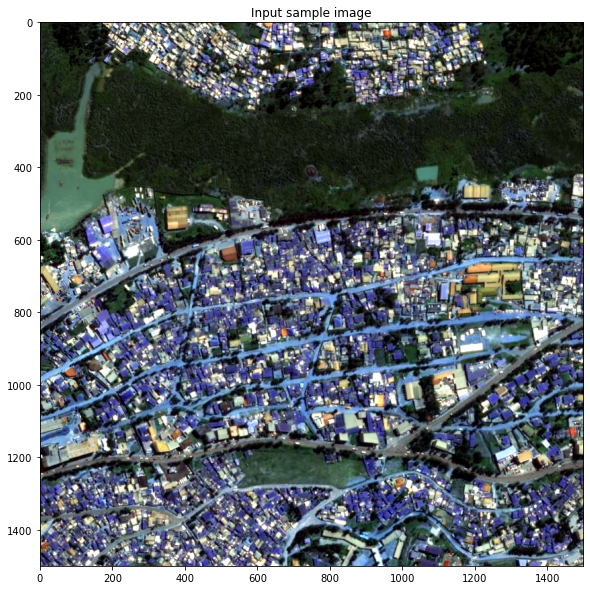

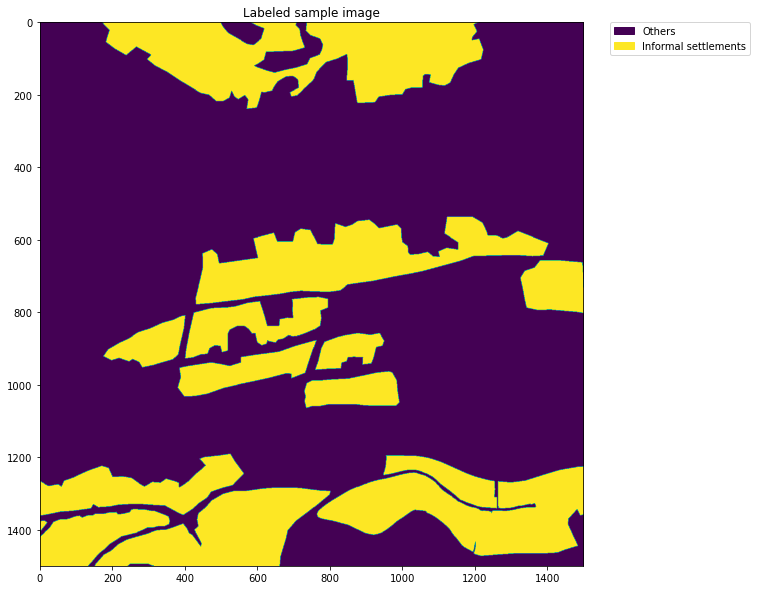

In [6]:
def visualize_labels(labels, fig_width=10, fig_height=10):
    """Function for visualizing the labels prepared from the reference images."""
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    values = np.unique(labels.ravel())
    im = plt.imshow(labels[:,:,0])
    a.set_title("Labeled sample image")
    # get the colors of the values, according to the 
    # colormap used by imshow
    colors = [im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    labels = ["Others", "Informal settlements"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), labels)]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def visualize_data(data, title, fig_width=10, fig_height=10):
    """Visualize the satellite image data."""
    # visualize only RGB bands
    data = data[:, :, 0:3]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    # perform stretching for better visualization
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    a.set_title(title)
    plt.imshow(data)

#Enter the name of tiles and its corresponding label for visualization
visualize_data(image_tiles["4"], "Input sample image")
visualize_labels(label_tiles["4"])

Sampling the input data for the model

In [7]:
PATCHSIZE = 64 #input size to the model
NBANDS = image_tiles["1"].shape[-1]

def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)



In [8]:
#Training Tiles
train_areas = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

# Testing Tiles
#test_areas = [ "7", "8", "9"]

In [9]:
# sample each training tile systematically in a gridwise manner
for tile in train_areas:
    X_toadd = gridwise_sample(image_tiles[tile], PATCHSIZE)
    Y_toadd = gridwise_sample(label_tiles[tile], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)

print("There are %i number of training patches" % (Xtrain.shape[0]))
print("There are %i number of label patches" % (Ytrain.shape[0]))

There are 4761 number of training patches
There are 4761 number of label patches


Let's check if patches and their associated labels look all right

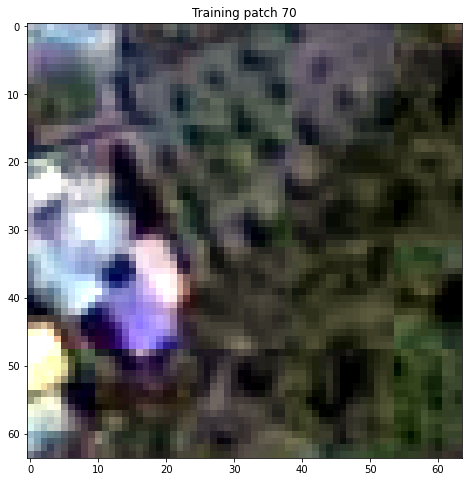

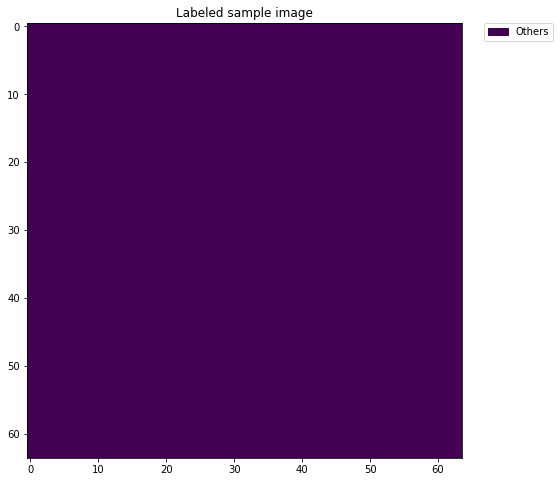

In [10]:
# Check if input patches and corresponding labels look all right
PATCH_NO = 70
visualize_data(Xtrain[PATCH_NO], "Training patch "+str(PATCH_NO), 8, 8)
visualize_labels(Ytrain[PATCH_NO], 8, 8)


In [11]:
#Conversion of labeled array into hot encoding
def to_categorical_4d(y, nc):
    """Convert a reclassed ground truth array to one-hot encoding
    
    Keyword arguments:
    y -- ground truth image
    nc -- number of classes
    """
    Y = np.zeros((y.shape[0],
                  y.shape[1],
                  y.shape[2],
                  nc),
                  dtype=np.int32)
    for h in range(y.shape[0]):
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                if y[h, i, j, 0] != 0:
                    Y[h, i, j, y[h, i, j, 0]-1] = 1
                else:
                    continue
    return Y

# transform target arrays to one-hot encodings
Ytrain = to_categorical_4d(Ytrain, 2)

In [12]:
#Allocating 80% of data for training and 20% of data for validation/testing
#This proportion is based on limited data for training the model
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=13)

In [13]:
#Checking again the shape of input data
print('Shape of input train data:', Xtrain.shape)
print('Shaoe of input train labels:', Ytrain.shape)
print('Shape of input test data:', Xtest.shape)
print('Shape of input test labels:', Ytest.shape)

Shape of input train data: (3808, 64, 64, 3)
Shaoe of input train labels: (3808, 64, 64, 2)
Shape of input test data: (953, 64, 64, 3)
Shape of input test labels: (953, 64, 64, 2)


## Part 2: Train the model

In [14]:
#Parameters
NUMBER_BANDS = 3
NUMBER_CLASSES = 2
NUMBER_EPOCHS = 20

In [15]:
#Customize loss function metrics for model behaviour

# Jaccard index realized as intersection over union (iou)
def mean_iou(y_true, y_pred):
    # Consider prediction greater than 0.5
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)
    union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
    return K.mean((inter + K.epsilon()) / (union + K.epsilon()))

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

#Recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#Precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#F1_Score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
#Function to build the model

# MobileNetV2 Encoder for U-net
def m_u_net(img):
    inputs = Input((PATCHSIZE, PATCHSIZE, NUMBER_BANDS), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=1.3)
    #encoder.trainable=False
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

#U-net
def unet(optimizer, nrows, ncols, nbands, nclasses):
    inputs = Input((PATCHSIZE, PATCHSIZE, NUMBER_BANDS))
    conv1_1 = Conv2D(16, (3, 3), padding='same')(inputs)
    bn1_1 = BatchNormalization(axis=3)(conv1_1)
    relu1_1 = Activation('relu')(bn1_1)
    conv1_2 = Conv2D(16, (3, 3), padding='same')(relu1_1)
    bn1_2 = BatchNormalization(axis=3)(conv1_2)
    relu1_2 = Activation('relu')(bn1_2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(relu1_2)
    
    conv2_1 = Conv2D(32, (3, 3), padding='same')(pool1)
    bn2_1 = BatchNormalization(axis=3)(conv2_1)
    relu2_1 = Activation('relu')(bn2_1)
    conv2_2 = Conv2D(32, (3, 3), padding='same')(relu2_1)
    bn2_2 = BatchNormalization(axis=3)(conv2_2)
    relu2_2 = Activation('relu')(bn2_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(relu2_2)
    
    conv3_1 = Conv2D(64, (3, 3), padding='same')(pool2)
    bn3_1 = BatchNormalization(axis=3)(conv3_1)
    relu3_1 = Activation('relu')(bn3_1)
    conv3_2 = Conv2D(64, (3, 3), padding='same')(relu3_1)
    bn3_2 = BatchNormalization(axis=3)(conv3_2)
    relu3_2 = Activation('relu')(bn3_2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(relu3_2)
    
    conv4_1 = Conv2D(128, (3, 3), padding='same')(pool3)
    bn4_1 = BatchNormalization(axis=3)(conv4_1)
    relu4_1 = Activation('relu')(bn4_1)
    conv4_2 = Conv2D(128, (3, 3), padding='same')(relu4_1)
    bn4_2 = BatchNormalization(axis=3)(conv4_2)
    relu4_2 = Activation('relu')(bn4_2)
    pool4 = MaxPooling2D(pool_size=(2, 2))(relu4_2)
    
    conv5_1 = Conv2D(256, (3, 3), padding='same')(pool4)
    bn5_1 = BatchNormalization(axis=3)(conv5_1)
    relu5_1 = Activation('relu')(bn5_1)
    conv5_2 = Conv2D(256, (3, 3), padding='same')(relu5_1)
    bn5_2 = BatchNormalization(axis=3)(conv5_2)
    relu5_2 = Activation('relu')(bn5_2)
    
    up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(relu5_2), relu4_2], axis=3)
    conv6_1 = Conv2D(128, (3, 3), padding='same')(up6)
    bn6_1 = BatchNormalization(axis=3)(conv6_1)
    relu6_1 = Activation('relu')(bn6_1)
    conv6_2 = Conv2D(128, (3, 3), padding='same')(relu6_1)
    bn6_2 = BatchNormalization(axis=3)(conv6_2)
    relu6_2 = Activation('relu')(bn6_2)
    
    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(relu6_2), relu3_2], axis=3)
    conv7_1 = Conv2D(64, (3, 3), padding='same')(up7)
    bn7_1 = BatchNormalization(axis=3)(conv7_1)
    relu7_1 = Activation('relu')(bn7_1)
    conv7_2 = Conv2D(64, (3, 3), padding='same')(relu7_1)
    bn7_2 = BatchNormalization(axis=3)(conv7_2)
    relu7_2 = Activation('relu')(bn7_2)
    
    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(relu7_2), relu2_2], axis=3)
    conv8_1 = Conv2D(32, (3, 3), padding='same')(up8)
    bn8_1 = BatchNormalization(axis=3)(conv8_1)
    relu8_1 = Activation('relu')(bn8_1)
    conv8_2 = Conv2D(32, (3, 3), padding='same')(relu8_1)
    bn8_2 = BatchNormalization(axis=3)(conv8_2)
    relu8_2 = Activation('relu')(bn8_2)
    
    up9 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(relu8_2), relu1_2], axis=3)
    conv9_1 = Conv2D(16, (3, 3), padding='same')(up9)
    bn9_1 = BatchNormalization(axis=3)(conv9_1)
    relu9_1 = Activation('relu')(bn9_1)
    conv9_2 = Conv2D(16, (3, 3), padding='same')(relu9_1)
    bn9_2 = BatchNormalization(axis=3)(conv9_2)
    relu9_2 = Activation('relu')(bn9_2)
    
    conv10 = Conv2D(nclasses, (1, 1), activation='softmax')(relu9_2)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model

In [17]:
opt = SGD(learning_rate=0.001, momentum=0.2)
unet_model = unet(opt, PATCHSIZE, PATCHSIZE, NUMBER_BANDS, 2)
unet_model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['acc', mean_iou, f1_m, precision_m])
unet_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          conv2d[0][0]           

Training the model

In [18]:
#earlystopper = EarlyStopping(patience=5)
#checkpointer = ModelCheckpoint('model_trained.h5', verbose=1, save_best_only=True, save_weights_only=True)
def train(model, data, labels):
    hist = model.fit(x=data,
                     y=labels,
                     epochs=NUMBER_EPOCHS,
                     verbose=2,
                     validation_data=(Xtest, Ytest)
                     #callbacks=[checkpointer]
                     )
    return hist

In [19]:
history1 = train(unet_model, Xtrain, Ytrain)

Train on 3808 samples, validate on 953 samples
Epoch 1/20
3808/3808 - 91s - loss: 0.9695 - acc: 0.4355 - mean_iou: 0.3332 - f1_m: 0.1439 - precision_m: 0.0958 - val_loss: 0.8382 - val_acc: 0.4320 - val_mean_iou: 0.3467 - val_f1_m: 0.1288 - val_precision_m: 0.0848
Epoch 2/20
3808/3808 - 90s - loss: 0.8088 - acc: 0.4905 - mean_iou: 0.3567 - f1_m: 0.2267 - precision_m: 0.1507 - val_loss: 0.7415 - val_acc: 0.5079 - val_mean_iou: 0.3669 - val_f1_m: 0.2425 - val_precision_m: 0.1607
Epoch 3/20
3808/3808 - 91s - loss: 0.7347 - acc: 0.5344 - mean_iou: 0.3761 - f1_m: 0.2924 - precision_m: 0.1947 - val_loss: 0.7132 - val_acc: 0.5447 - val_mean_iou: 0.3848 - val_f1_m: 0.3001 - val_precision_m: 0.1974
Epoch 4/20
3808/3808 - 94s - loss: 0.6943 - acc: 0.5675 - mean_iou: 0.3927 - f1_m: 0.3427 - precision_m: 0.2277 - val_loss: 0.6887 - val_acc: 0.5727 - val_mean_iou: 0.4006 - val_f1_m: 0.3423 - val_precision_m: 0.2253
Epoch 5/20
3808/3808 - 92s - loss: 0.6711 - acc: 0.5916 - mean_iou: 0.4076 - f1_m: 0.

## Part 3: Testing the model

The evaluation of the performannce of the model

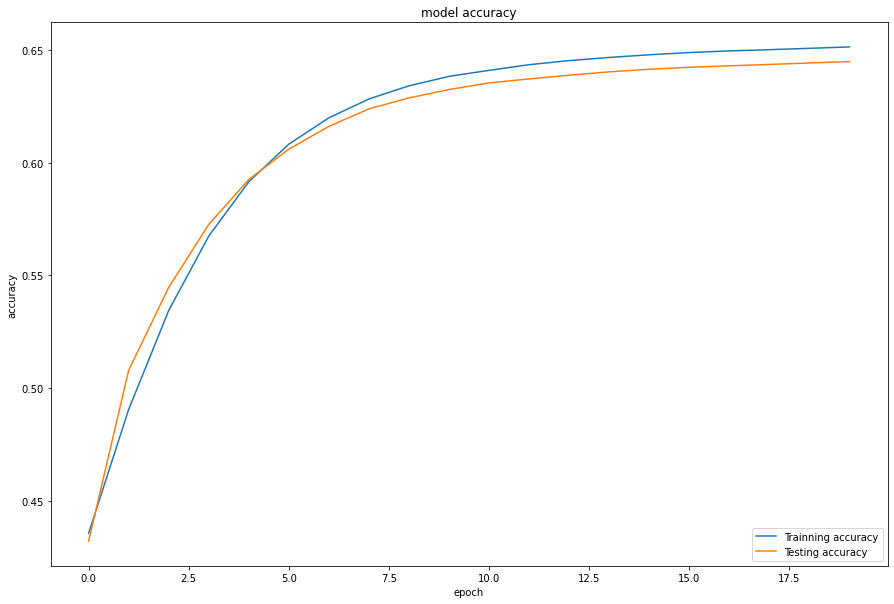

In [20]:
# summarize history for accuracy
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Trainning accuracy', 'Testing accuracy'], loc='lower right')
plt.show()

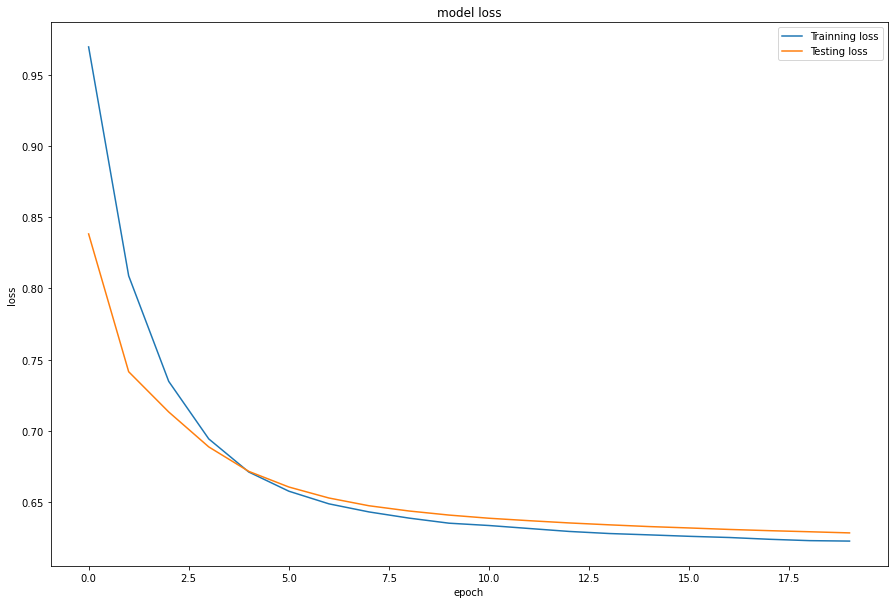

In [21]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Trainning loss', 'Testing loss'], loc='upper right')
plt.show()

## Part 4: Apply the model to predict for the new dataset

In [22]:
# Prepare the inference data for to be feed in the model
# Load a new image tile to extract its dimensions
os.chdir(r"D:\informal")
ds, new_image = raster.read('8.tif')

inf_area = ["8"]  # Inferencing tile (Remember the size of tiles is 1500X1500). Here you can also try for tile 9
for tile in inf_area:
    newX_toadd = gridwise_sample(image_tiles[tile], PATCHSIZE)
    Xinf = np.concatenate((Xtrain, newX_toadd), axis=0)

print("There are %i number of inferencing patches" % (Xinf.shape[0]))
print('Shape of the inference patches', Xinf.shape)


Warning! matplotlib_scalebar library not found. You may not be able to export map directly.


In [23]:
# Un comment the lines below if to check how inference patch look like bycalling visualizationfunction
#INFERENCE_PATCH_NO = int(input('Insert the number in range of the total number of inference patches: '))
#visualize_data(Xinf[INFERENCE_PATCH_NO], "Inference patch ", 8, 8)

# Prediction on inference patches and export the probability raster
output_image = unet_model.predict(Xinf)
prediction_image = output_image[:,1]

#You may need to reshape the prediction, hence uncomment the line below
#prediction_image = np.reshape(prediction_image, (ds.RasterYSize, ds.RasterXSize))

os.chdir(r"D:\informal") #direction for saving the output

image_out = 'classified_tile8.tif' #Set the name and extension for output image
raster.export(prediction_image, ds, filename=image_out, dtype='float')
